## MAX POOLING

### MaxPooling_Kernel Idea

### Key Concepts:
1. **Thread Indexing:**
   - The kernel uses a global thread index to assign each thread a specific element in the output array. This parallelizes the pooling operation, allowing multiple elements to be processed simultaneously.

2. **Block and Grid Design**
   - We use 1D Block and 1D Grid to handle all pixel of output image. Block Size = 256 for best performance.
   
3. **Stride and Mapping:**
   - Stride is used to calculate the position of the 2x2 region in the input array corresponding to each output element. This helps to determine which elements in the input array should be considered for the max operation.

4. **Max Operation:**
   - For each output element, the kernel compares four elements in the input array and selects the maximum value. This value is then stored in the output array.


### MaxPooling Kernel Pseudocode

```text
MaxPooling_Kernel(input, output, num_channels, output_height, output_width):
    index = calculate_grid_index()  // Get the global thread index
    total_output_elements = get_size_of(output)  // Total number of elements in the output array

    if index < total_output_elements:
        
        Calculate index for batch and current channel

        Calculate index for output image
        
        Calculate index for input image

        # Perform Max Operators For 4 Input Pixel
        max_val = max(pixel_1, pixel_2, pixel_3, pixel_4)  


        # Update pixel value of correspond output pixel
        output[batch_idx, channel_idx, row, col] = max_val  


## Optimize Double Convolution And Data Transfer

### Combie Convolution, BatchNorm 2D, Relu
#### Original
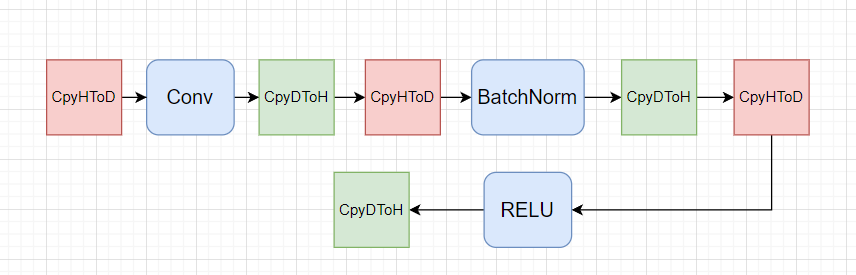
### Optimized
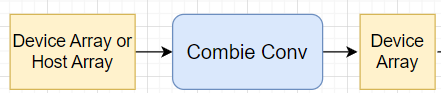

### Reduce data transfer
#### Original
![](original_combie_conv.png)
#### Optimized
![](optimize_combie_conv.png)
### Optimized for maxpooling
![](optimize_maxpool.png)

### Table Show Number of Copies Per Block
|        | **Original** | **Optimized** |
|--------|--------------|---------------|
| **down_1** | 12 copy       | 1 copy        |
| **down_2** | 16 copy       | 0 copy        |
| **down_3** | 16 copy       | 0 copy        |
| **down_4** | 16 copy       | 0 copy        |
| **down_5** | 16 copy       | 0 copy        |
| **up_1**   | 16 copy       | 1 copy        |
| **up_2**   | 16 copy       | 1 copy        |
| **up_3**   | 16 copy       | 1 copy        |
| **up_4**   | 16 copy       | 1 copy        |
| **out**    | 2 copy       | 1 copy        |
| **total**  | 142 copy      | 6 copy        |

## DEMO

In [1]:
import torch.nn as nn
from model_numba.Layers.Layers import batchNorm2D, Convolution2D_GPU
import numpy as np
from torchvision import transforms
from model_numba.unet_cuda import Double_Conv, Unet_Cuda
from PIL import Image
import torch
import time
from numba import cuda

transform = transforms.Compose(
    [
        transforms.Resize((512, 512)),
        transforms.ToTensor()
    ]
)
image = Image.open('test.jpg')
image = transform(image).unsqueeze(0)
image.shape

torch.Size([1, 3, 512, 512])

In [2]:
from model.unet import U_net
model = U_net(1).eval()
weight = torch.load('weights/weights.pth')
model.load_state_dict(weight)

numba_model = Unet_Cuda(1).eval()

In [3]:
start = time.time()
out = model(image)
end = time.time()

print(f'Torch Runtime: {end- start} s')

start = time.time()
out_numba = numba_model(image.cpu().detach().numpy())
end = time.time()

print(f'Numba Runtime: {end- start} s')

mean = np.mean(np.abs(out.cpu().detach().numpy()- out_numba))
max = np.max(np.abs(out.cpu().detach().numpy()- out_numba))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')



Torch Runtime: 0.7746009826660156 s
Numba Runtime: 1.5709187984466553 s
Mean Difference:  0.000504
Max Difference:  0.011502


In [4]:
mean = np.mean(np.abs(model.d5.cpu().detach().numpy()- numba_model.d5.copy_to_host()))
max = np.max(np.abs(model.d5.cpu().detach().numpy()- numba_model.d5.copy_to_host()))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000000
Max Difference:  0.000007


In [5]:
mean = np.mean(np.abs(model.u1.cpu().detach().numpy() - numba_model.u1.copy_to_host()))
max = np.max(np.abs(model.u1.cpu().detach().numpy() - numba_model.u1.copy_to_host()))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000014
Max Difference:  0.000922


In [6]:
mean = np.mean(np.abs(model.u2.cpu().detach().numpy() - numba_model.u2.copy_to_host()))
max = np.max(np.abs(model.u2.cpu().detach().numpy() - numba_model.u2.copy_to_host()))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000016
Max Difference:  0.000747


In [7]:
mean = np.mean(np.abs(model.u3.cpu().detach().numpy() - numba_model.u3.copy_to_host()))
max = np.max(np.abs(model.u3.cpu().detach().numpy() - numba_model.u3.copy_to_host()))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000016
Max Difference:  0.000887


In [8]:
mean = np.mean(np.abs(model.u4.cpu().detach().numpy() - numba_model.u4.copy_to_host()))
max = np.max(np.abs(model.u4.cpu().detach().numpy() - numba_model.u4.copy_to_host()))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000028
Max Difference:  0.000770


In [9]:
mean = np.mean(np.abs(out.cpu().detach().numpy()- out_numba))
max = np.max(np.abs(out.cpu().detach().numpy()- out_numba))
print(f'Mean Difference: {mean : .6f}')
print(f'Max Difference: {max: .6f}')

Mean Difference:  0.000504
Max Difference:  0.011502


| **Block**                                                | **Different (Compare to pytorch)**           |
|----------------------------------------------------------|-------------------------|
| down_5                                                   | 0.000000                |
| up_1 | 0.000014 |
| up_2 |  0.000016 |
| up_3 | 0.000016 |
| up_4 | 0.000028 |
| Ouput | 0.000504 |

## Assignment Task Table



| **Task**                                                         | **Assigned To** |
|------------------------------------------------------------------|-----------------|
| Write MaxPooling Kernel                                           | Huy             |
| Combine Conv, batchNorm2d, and ReLU into a single kernel          | Huy             |
| Attach all kernels to U-Net and make it work                      | Huy             |
| Optimize Data Transfer                                            | Huy             |
| Write report                                                      | Huy, Dat        |
| Write Transpose Convolution on CPU                                | Dat             |


### What our group hasn't done yet


| **Task**                                                         | 
|------------------------------------------------------------------|
| Write Transpose Convolution 2D Kernel                            |
| Make Unet GPU verion able to change background of portrait image |    
| Make UI for our project (web or app)                             |
| (Optinal) Make Unet able to change background of recorded video  |
| (Optinal) Optimize Convolution to run faster than current version|